# Exploring BaccMiX Output

#### This notebook takes a preliminary look the BACCARAT output for the MiX detector
#### Author: Chami A

In [2]:
# Python imports
import functools

import numpy as np
import awkward as awk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2")

params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

import uproot

#### ROOT Files

In [3]:
# Location of LZap files
filePath = '/global/u1/c/chami/MiX/neutronStudies/'

# Add files in the location above to the list (right now I only have one file, but this is set up for multiple large files.)
fileNames = ['neutronTest10k_1']

fullNames = [filePath + name + '.root' for name in fileNames]

numEntries = uproot.tree.numentries(fullNames, treepath = 'tree')
f'{numEntries} events in root files.'

'9229 events in root files.'

#### Variables to be loaded in

In [4]:
# These data are common to all interactions in an event. Write directly into a pandas frame.
pandasVariablesList = ['fPrimaryParPosX_mm',
                       'fPrimaryParPosY_mm',
                       'fPrimaryParPosZ_mm',
                       'cPrimaryParName',
                       'fPrimaryParEnergy_keV',
                       'fPrimaryParTime_ns',
                       'iRecordSize',
                       'iEvtN',
                       'fTotEDep']

# These data are lists of lists, putting them in pandas directly is inefficient
jaggedArraysVariableList = ['iParticleID',
                            'cParticleName'
                            'fKEnergy_keV',
                            'fDirectionX',
                            'fDirectionY',
                            'fDirectionZ',
                            'fEnergyDep_keV',
                            'fPositionX_mm',
                            'fPositionY_mm',
                            'fPositionZ_mm',
                            'cCreatorProcess',
                            'cStepProcess',
                            'cVolumeName',
                            'fStepTime']

In [5]:
%%time

MiXJaggedArrayData = uproot.open('/global/u1/c/chami/MiX/neutronStudies/neutronTest10k_1.root')

# Write the event level data directly into a pandas dataframe
eventDF = MiXJaggedArrayData['tree'].pandas.df(pandasVariablesList, flatten = True).reset_index(drop = True)

# Write the interaction level data into jagged arrays
PID = MiXJaggedArrayData['tree'].array('iParticleID')
kEnergy, energyDep = MiXJaggedArrayData['tree'].arrays(['fKEnergy_keV', 'fEnergyDep_keV'], outputtype = tuple)
dirX, dirY, dirZ = MiXJaggedArrayData['tree'].arrays(['fDirectionX', 'fDirectionY', 'fDirectionZ'], outputtype = tuple)
posX, posY, posZ = MiXJaggedArrayData['tree'].arrays(['fPositionX_mm', 'fPositionY_mm', 'fPositionZ_mm'], outputtype = tuple)

CPU times: user 4.1 s, sys: 890 ms, total: 4.99 s
Wall time: 13.8 s


In [13]:
eventEverythingDF = MiXJaggedArrayData['tree'].pandas.df()

ValueError: cannot use flatten=True on branches with different jagged structure, such as electrons and muons (different, variable number of each per event); either explicitly select compatible branches, such as ["MET_*", "Muon_*"] (scalar and variable per event is okay), or set flatten=False

In [7]:
# Mask for the neutron interactions.
neutronMask = PID == 2112

# Mask for active volume.
activeVolumeRadius = 31.75 # Millimeters
activeVolumeHeight = 35.48 # Millimeters

radialMask = posX**2 + posY**2 < 31.75**2
zLowMask = posZ > 0
zHighMask = posZ < activeVolumeHeight

# All masks (interaction level) - apply this first to select neutron-only interactions
allMasks = functools.reduce(np.logical_and, [neutronMask, radialMask, zLowMask, zHighMask])
# Event level mask - now apply this to select events that have neutron interactions in active volume.
## Otherwise the jagged array will have empty list elements.
eventMask = PID[allMasks].counts != 0

In [8]:
kEnergy_n, energyDep_n = (kEnergy[allMasks][eventMask], energyDep[allMasks][eventMask])
dirX_n, dirY_n, dirZ_n = (dirX[allMasks][eventMask], dirY[allMasks][eventMask], dirZ[allMasks][eventMask])
posX_n, posY_n, posZ_n = (posX[allMasks][eventMask], posY[allMasks][eventMask], posZ[allMasks][eventMask])

In [9]:
eventDF_n = eventDF.mask( np.tile(~eventMask, (len(eventDF.columns),1)).T ).dropna().reset_index()

In [10]:
eventDF_n

index  fPrimaryParPosX_mm  fPrimaryParPosY_mm  fPrimaryParPosZ_mm  \
0         6               150.0           -0.710853           15.626124   
1        10               150.0           -0.957553           12.264341   
2        15               150.0           -8.973920           22.955917   
3        26               150.0            0.528796           12.294832   
4        33               150.0           -8.989380           23.169862   
...     ...                 ...                 ...                 ...   
1114   9185               150.0           -2.385283           25.624869   
1115   9187               150.0           -2.511302           11.509195   
1116   9195               150.0            2.954292           15.280120   
1117   9197               150.0           -9.903464           20.585293   
1118   9211               150.0           -2.407286           22.228583   

       iEvtN    fTotEDep  
0        8.0   54.158906  
1       13.0    0.000000  
2       18.0  109.900031  
3       30.0  982.620020  
4       39.0    0.000000  
...      ...         ...  
1114  9953.0    4.644101  
1115  9955.0    0.000000  
1116  9963.0    2.318086  
1117  9966.0   66.813211  
1118  9981.0    0.000000  

[1119 rows x 6 columns]

#### Read in the ROOT files into Pandas DataFrames using uproot
I like Pandas, but you could use numpy from the start.

In [57]:
%%time

neutronsMix = pd.DataFrame().astype(dtype = float, errors = 'ignore')

# Don't make this number too big. 
entryStepSize = 1000
# Open each file and append information to the df
for frame in uproot.pandas.iterate(fullNames, treepath = 'tree', branches = variablesList, flatten = False, entrysteps = entryStepSize):
    
    neutronsMix = pd.concat([neutronsMix, frame], axis = 0, ignore_index = True)
    
print('Read all BACCARAT files successfully! Total %s events' % numEntries)

# Remove the pesky C-types in front of the variable names
neutronsMix.rename(mapper = lambda name : name[1:], axis = 'columns', inplace = True)
neutronsMix = neutronsMix.astype(dtype = float, errors  ='ignore')

Read all BACCARAT files successfully! Total 936 events
CPU times: user 1.09 s, sys: 227 ms, total: 1.31 s
Wall time: 1.57 s


In [58]:
neutronsMix

PrimaryParPosX_mm      PrimaryParPosY_mm      PrimaryParPosZ_mm    EvtN  \
0             [150.0]   [-4.425762384069479]  [-24.649371608724998]     1.0   
1             [150.0]  [-3.6687105178063275]  [-27.839916159335743]     2.0   
2             [150.0]  [-3.3311321632535416]  [-26.807240202883502]     3.0   
3             [150.0]    [7.283681278910347]  [-26.466013580977506]     4.0   
4             [150.0]    [3.931052967000877]  [-13.327810852913558]     5.0   
..                ...                    ...                    ...     ...   
931           [150.0]  [-1.3152789348732092]  [-19.085228346122918]   996.0   
932           [150.0]   [-1.821486794842503]  [-15.028108771472775]   997.0   
933           [150.0]    [-4.15945509038322]  [-27.740643256662658]   998.0   
934           [150.0]   [-7.760652616116866]  [-13.909166748910163]   999.0   
935           [150.0]   [0.5612001614415796]  [-16.378684697589303]  1000.0   

                                            ParticleID         VolumeName  \
0                                         [2112, 2112]  b'LiquidXeTarget'   
1    [2112, 2112, 22, 22, 22, 22, 11, 11, 11, 11, 1...  b'LiquidXeTarget'   
2                                   [2112, 2112, 2112]  b'LiquidXeTarget'   
3                                   [2112, 2112, 2112]  b'LiquidXeTarget'   
4                                   [2112, 2112, 2112]  b'LiquidXeTarget'   
..                                                 ...                ...   
931                                 [2112, 2112, 2112]  b'LiquidXeTarget'   
932  [2112, 2112, 2112, 2112, 1000541310, 100054131...  b'LiquidXeTarget'   
933                                       [2112, 2112]  b'LiquidXeTarget'   
934  [2112, 12, 12, 22, 22, 22, 11, 11, 11, 11, 11,...  b'LiquidXeTarget'   
935  [2112, 2112, 22, 22, 11, 11, 11, 11, 11, 11, 1...  b'LiquidXeTarget'   

                                          ParticleName  \
0                                  b'neutron&neutron&'   
1    b'\x00\x00"\x96neutron&neutron&gamma&gamma&gam...   
2                          b'neutron&neutron&neutron&'   
3                          b'neutron&neutron&neutron&'   
4                          b'neutron&neutron&neutron&'   
..                                                 ...   
931                        b'neutron&neutron&neutron&'   
932  b'neutron&neutron&neutron&neutron&Xe131&Xe131&...   
933                                b'neutron&neutron&'   
934  b'\x00\x00a&neutron&nu_e&nu_e&gamma&gamma&gamm...   
935  b'\x00\x00,eneutron&neutron&gamma&gamma&e-&e-&...   

                                           KEnergy_keV  \
0                                     [2500.0, 2500.0]   
1    [2500.0, 1629.8117951640734, 203.2036169672178...   
2     [2500.0, 2409.3873210680385, 2409.3873210680385]   
3         [2500.0, 2442.14497277369, 2442.14497277369]   
4     [2500.0, 1580.2584057269087, 1580.2584057269087]   
..                                                 ...   
931   [2500.0, 2365.7654620629955, 2365.7654620629955]   
932  [2500.0, 2472.6535944397483, 2472.653594439748...   
933                       [2500.0, 2494.3894454280553]   
934  [2500.0, 262.8541709854128, 262.8541709854128,...   
935  [2500.0, 131.49912130757002, 262.3714832285112...   

                                            DirectionX  \
0                                         [-1.0, -1.0]   
1    [-1.0, -0.9222408394844128, 0.2830709805573345...   
2    [-1.0, -0.20459919758160727, -0.20459919758160...   
3    [-1.0, -0.10804536983812402, -0.10804536983812...   
4    [-1.0, -0.011949946408113676, -0.0119499464081...   
..                                                 ...   
931   [-1.0, 0.44631713516516935, 0.44631713516516935]   
932  [-1.0, -0.47387521967212876, -0.47387521967212...   
933                        [-1.0, -0.9376743720300734]   
934  [-1.0, -0.06791832424319592, -0.06791832424319...   
935  [-1.0, 0.19895225746083361, 0.1819647022134994...   

                                       

In [59]:
neutronsMix.VolumeName.value_counts()

b'LiquidXeTarget'    936
Name: VolumeName, dtype: int64

##### Neutron source shape
Firstly, as a sanity check, see if the source geometry is as specified in the BACCARAT macro by plotting the parent particle locations. My source is a circular disk at $x = 150$ mm. 

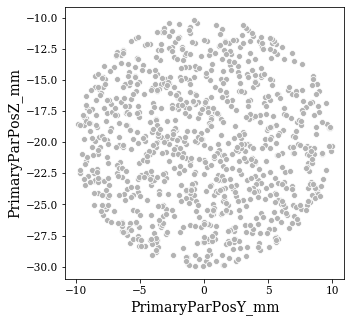

In [7]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = 'PrimaryParPosY_mm',
                y = 'PrimaryParPosZ_mm',
                data = neutronsMix,
                color = palette[-1])
plt.show()

##### Numbers of interactions
The dataframe was not flattened so some elements are lists. The length of the each list corresponds to the number of interactions each particle and its children underwent. Some events have up to ~$30,000$ interactions. Of course, the neutron won't scatter this much so much of this is unneeded information.

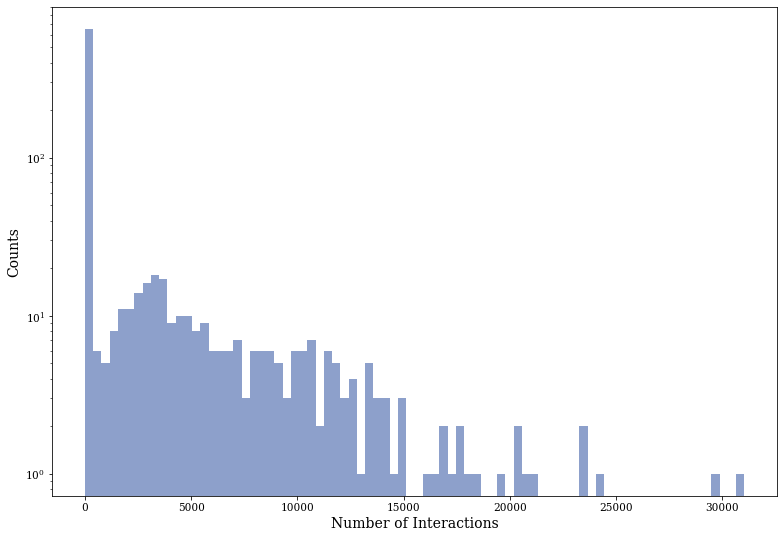

In [8]:
numInteractions = []
for i in range(len(neutronsMix)):
    numInteractions.append(len(neutronsMix.DirectionY.iloc[i]))
plt.hist(numInteractions, bins = 80, log = True, color = palette[2])
plt.xlabel('Number of Interactions')
plt.ylabel('Counts')
plt.show()

##### Total energy deposited by each particle

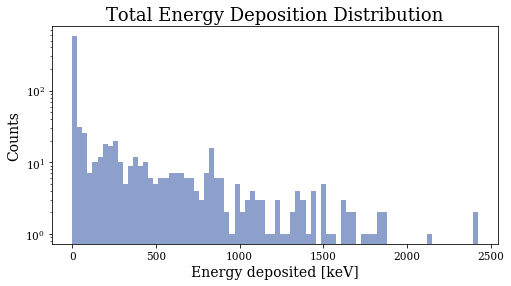

In [48]:
plt.figure(figsize = (8,4))
plt.hist(neutronsMix.TotEDep, bins = 80, log = True, color = palette[2])
plt.xlabel('Energy deposited [keV]')
plt.ylabel('Counts')
plt.title('Total Energy Deposition Distribution')
plt.show()

Generally, the more energy was deposited, the more the times the particle scattered. However, there are some particles that dumped a lot of energy with just a few scatters.

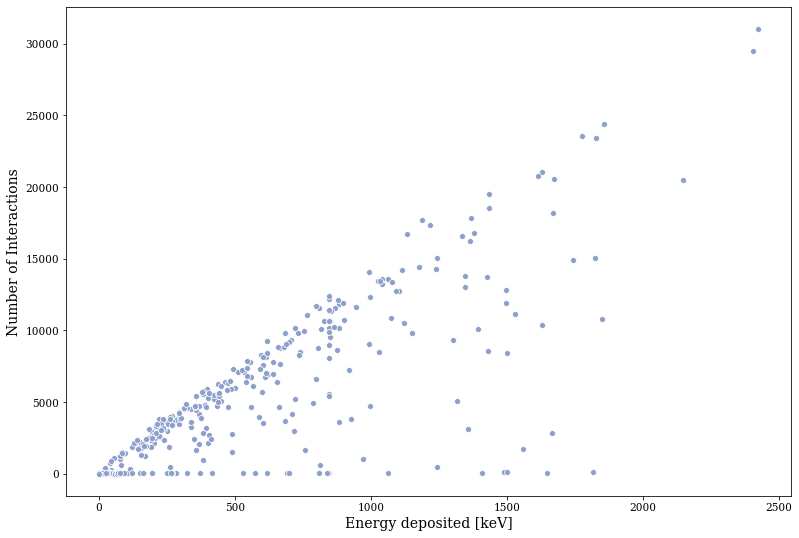

In [10]:
sns.scatterplot(x = neutronsMix.TotEDep, y = numInteractions, color = palette[2])
plt.xlabel('Energy deposited [keV]')
plt.ylabel('Number of Interactions')
plt.show()

#### Unpack the dataframe
Pandas dataframes are not meant to be used with list-like elements, so let's unpack.
The solution below is not suitable for large dataframes and can be modified to be faster, so please let me know if you have ideas.
It's good for now though.

In [11]:
# The list-like variables to be unpacked
unpackVariablesList = ['ParticleID',
                       'KEnergy_keV',
                       'DirectionX',
                       'DirectionY',
                       'DirectionZ',
                       'EnergyDep_keV',
                       'PositionX_mm',
                       'PositionY_mm',
                       'PositionZ_mm']

PDG references for particle IDs:

http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf

https://indico.ph.tum.de/event/3955/sessions/752/attachments/2741/3099/Day3_Physics.pdf

In [12]:
particlePDG = {11: 'electron',
               -11: 'positron',
               22: 'photon',
               2112: 'neutron',
               1000541310: '131Xe',
               1000541290: '129Xe',
               1000541320: '132Xe',
               1000541340: '134Xe',
               1000541360: '136Xe',
               1000541300: '130Xe',
               1000541280: '128Xe',
               1000541240: '124Xe',
               12: 'e-neutrino'}

In [13]:
def explodeLists(df, columnsToUnpack, neutronsOnly = True):
    """This function takes a dataframe with lists as elements in some columns,
       unpacks the lists vertically so each list entry gets its own row, 
       and returns this modified dataframe. Information in other columns are repeated.
       Performance is not great so take care when using it on large dataframes.
       Could be improved with numpy."""
    otherColumns = df.columns.difference(columnsToUnpack).to_list()
    # Unpack the first column keeping the normal columns repeated
    dfExploded_ = df[otherColumns + [columnsToUnpack[0]]].explode(columnsToUnpack[0])
    
    # Unpack the rest of the columns and concatenate
    for column in columnsToUnpack[1:]:
        dfExploded_ = pd.concat([dfExploded_, df[column].explode()], axis = 1)
        
    # Discard all particle scatters but neutrons. 2112 is from the PDG Monte Carlo numbering scheme
    if neutronsOnly:
        dfExploded_ = dfExploded_.loc[dfExploded_.ParticleID == 2112]

    # Create a new index that counts number of interactions elapsed
    dfExploded_['InteractionIndex'] = dfExploded_.groupby('EvtN').cumcount().astype('category')
    
    # Map the particle IDs to particle names
    ## Omit this intensive step once familiar with IDs
    dfExploded_['ParticleID'] = dfExploded_.ParticleID.map(particlePDG).astype('category')
    
    return dfExploded_

First take a look at what kinds of particles are produced. You can do this with the `ParticleName` branch in the ROOT file but for some reason the string formatting is weird, so consider
the `ParticleID` branch.

In [14]:
%time dfExploded_All = explodeLists(neutronsMix, unpackVariablesList, neutronsOnly = False)

CPU times: user 16.9 s, sys: 3.51 s, total: 20.4 s
Wall time: 18.3 s


In [15]:
dfExploded_All.ParticleID.value_counts()

electron      1942005
photon           3557
neutron          3549
positron         3318
131Xe             447
129Xe             444
132Xe             399
134Xe             180
136Xe             156
130Xe              72
128Xe              36
e-neutrino         11
124Xe               3
Name: ParticleID, dtype: int64

To track the neutrons through the detector, lets discard these other particles. 

In [17]:
# Don't filter the dfExploded_All array since the interaction indices will get messed up
%time dfExploded = explodeLists(neutronsMix, unpackVariablesList)

CPU times: user 16.4 s, sys: 2.63 s, total: 19.1 s
Wall time: 17.2 s


#### Scatters in the detector
Note only the liquid xenon is recording scatters. `InteractionIndex` keeps track of scatter ordinality, i.e. `0` is the first scatter, `1` is the second, and so on.

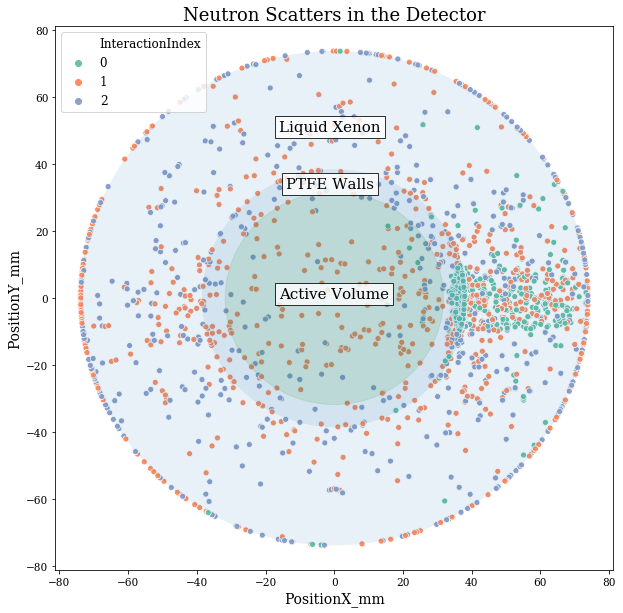

In [18]:
# Keeping only first three interactions
dfFirstFew = dfExploded.loc[(dfExploded.InteractionIndex == 0) | 
                            (dfExploded.InteractionIndex == 1) |
                            (dfExploded.InteractionIndex == 2)]

plt.figure(figsize = (10,10))

# Add circles to show detector boundaries
cryostatBoundary = plt.Circle((0, 0), 73.812, alpha = 0.1, label = 'Liquid Xenon')
PTFEBoundary = plt.Circle((0, 0), 38.5, alpha = 0.1, label = 'PTFE')
activeVolumeBoundary = plt.Circle((0, 0), 31.75, color = 'green', alpha = 0.1, label = 'Active Volume')

plt.gcf().gca().add_artist(cryostatBoundary)
plt.gcf().gca().add_artist(PTFEBoundary)
plt.gcf().gca().add_artist(activeVolumeBoundary)

# The hue argument plots different colors for each Interation Index
sns.scatterplot(x = 'PositionX_mm',
                y = 'PositionY_mm',
                data = dfFirstFew,
                hue = 'InteractionIndex',
                palette = palette[:3])

plt.text(-16, 50, 'Liquid Xenon', bbox=dict(facecolor='white', alpha=0.8), fontsize = 15)
plt.text(-14, 33, 'PTFE Walls', bbox=dict(facecolor='white', alpha=0.8), fontsize = 15)
plt.text(-16, 0, 'Active Volume', bbox=dict(facecolor='white', alpha=0.8), fontsize = 15)

plt.title('Neutron Scatters in the Detector')
plt.legend()
plt.show()

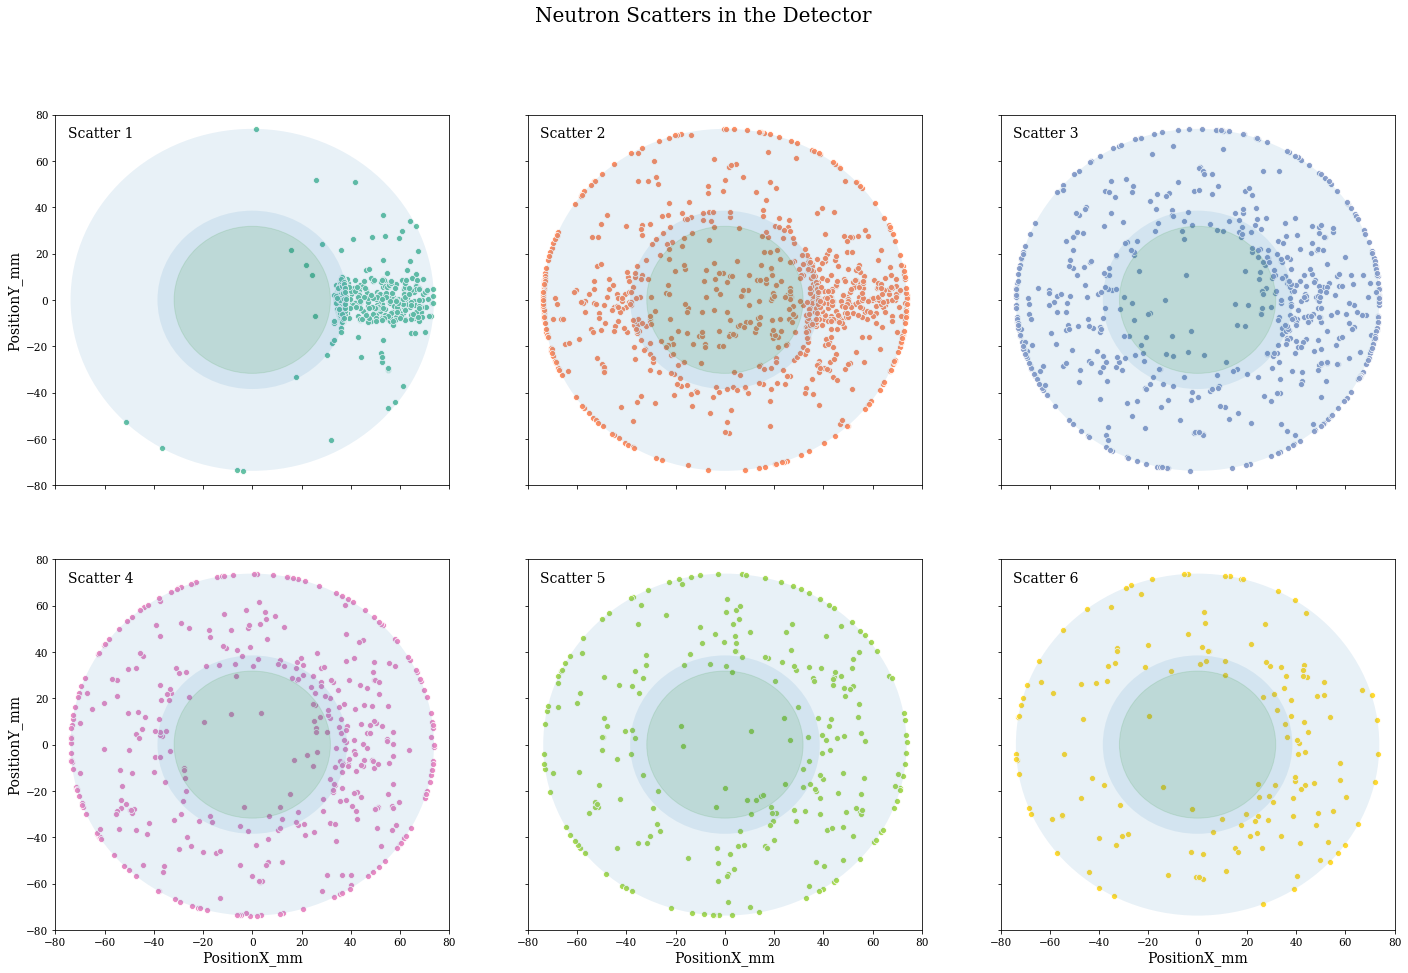

In [19]:
# Looking at each neutron scatter individually

fig, axes = plt.subplots(2, 3, figsize = (24, 15), sharey = True, sharex = True)

for i, ax in enumerate(axes.flatten()):
    
    dfLoop = dfExploded.loc[(dfExploded.InteractionIndex == i)]
    
    cryostatBoundary = plt.Circle((0, 0), 73.812, alpha = 0.1, label = 'Liquid Xenon')
    PTFEBoundary = plt.Circle((0, 0), 38.5, alpha = 0.1, label = 'PTFE')
    activeVolumeBoundary = plt.Circle((0, 0), 31.75, color = 'green', alpha = 0.1, label = 'Active Volume')

    ax.add_artist(cryostatBoundary)
    ax.add_artist(PTFEBoundary)
    ax.add_artist(activeVolumeBoundary)

    sns.scatterplot(x = 'PositionX_mm',
                    y = 'PositionY_mm',
                    data = dfLoop,
                    color = palette[i],
                    ax = ax)
    ax.text(-75, 70, 'Scatter %s' % str(i+1), fontsize = 14)
    ax.set_xlim((-80, 80))
    ax.set_ylim((-80, 80))
    
fig.suptitle('Neutron Scatters in the Detector', fontsize = 20)
plt.show()

Looks like the neutrons scatter through the xenon volume pretty quickly.

##### Energy Deposition for a Singular Event
This is an example of an event where energy was deposited along many steps.

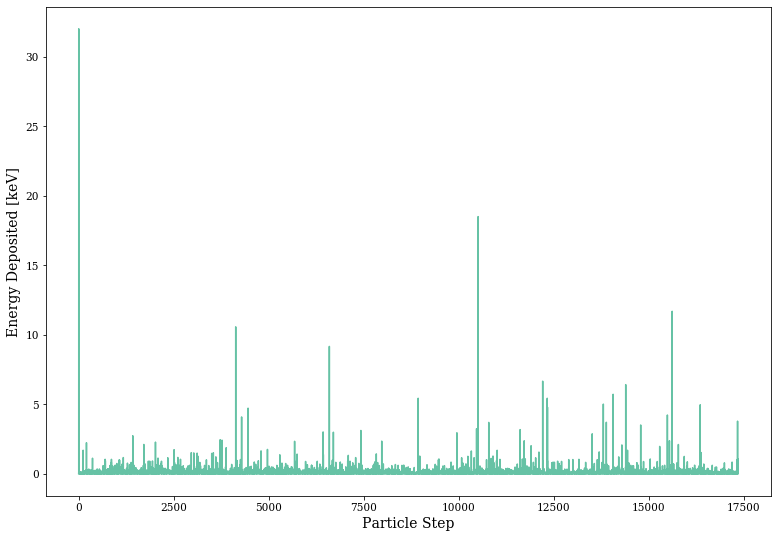

In [33]:
eventIndex = 6

plt.plot(neutronsMix.EnergyDep_keV.iloc[eventIndex], color = palette[0])
plt.xlabel('Particle Step')
plt.ylabel('Energy Deposited [keV]')
plt.show()

Just for fun we can look at the track of the particle through the detector.

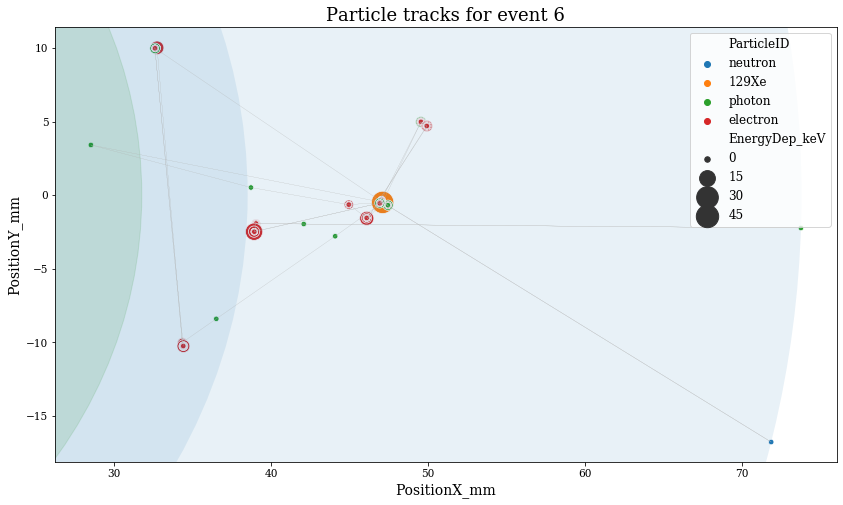

In [45]:
dfSingleParticle = dfExploded_All.loc[dfExploded_All.EvtN == eventIndex + 1]

cryostatBoundary = plt.Circle((0, 0), 73.812, alpha = 0.1, label = 'Liquid Xenon')
PTFEBoundary = plt.Circle((0, 0), 38.5, alpha = 0.1, label = 'PTFE')
activeVolumeBoundary = plt.Circle((0, 0), 31.75, color = 'green', alpha = 0.1, label = 'Active Volume')

plt.figure(figsize = (14, 8))

plt.gcf().gca().add_artist(cryostatBoundary)
plt.gcf().gca().add_artist(PTFEBoundary)
plt.gcf().gca().add_artist(activeVolumeBoundary)

sns.scatterplot(x = 'PositionX_mm',
                y = 'PositionY_mm',
                data = dfSingleParticle,
                hue = 'ParticleID',
                size = 'EnergyDep_keV',
                sizes = (30, 500))
singleParticlePositions = dfSingleParticle[['PositionX_mm', 'PositionY_mm']].to_numpy()
for i in range(len(singleParticlePositions) - 1):
    distanceBetweenPoints = np.hypot(*(singleParticlePositions[i+1] - singleParticlePositions[i]))
    # Draw arrow only if points are separable
    if distanceBetweenPoints > 0.1:
        plt.arrow(*singleParticlePositions[i], *(singleParticlePositions[i+1] - singleParticlePositions[i]), color = palette[-1], linewidth = 0.1)
plt.title('Particle tracks for event %s' % eventIndex)
plt.show()

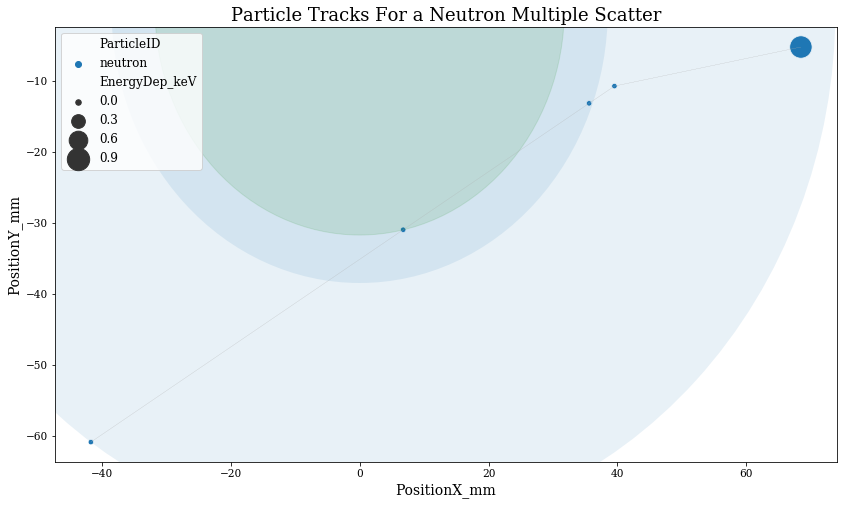

In [44]:
# Another event, neutrons only.
dfSingleParticle_n = dfExploded.loc[dfExploded.EvtN == 6]

cryostatBoundary = plt.Circle((0, 0), 73.812, alpha = 0.1, label = 'Liquid Xenon')
PTFEBoundary = plt.Circle((0, 0), 38.5, alpha = 0.1, label = 'PTFE')
activeVolumeBoundary = plt.Circle((0, 0), 31.75, color = 'green', alpha = 0.1, label = 'Active Volume')

plt.figure(figsize = (14, 8))
plt.gcf().gca().add_artist(cryostatBoundary)
plt.gcf().gca().add_artist(PTFEBoundary)
plt.gcf().gca().add_artist(activeVolumeBoundary)

sns.scatterplot(x = 'PositionX_mm',
                y = 'PositionY_mm',
                data = dfSingleParticle_n,
                hue = 'ParticleID',
                size = 'EnergyDep_keV',
                sizes = (30, 500))
singleParticlePositions = dfSingleParticle_n[['PositionX_mm', 'PositionY_mm']].to_numpy()
for i in range(len(singleParticlePositions) - 1):
    distanceBetweenPoints = np.hypot(*(singleParticlePositions[i+1] - singleParticlePositions[i]))
    # Draw arrow only if points are separable
    if distanceBetweenPoints > 0.1:
        plt.arrow(*singleParticlePositions[i], *(singleParticlePositions[i+1] - singleParticlePositions[i]), color = palette[-1], linewidth = 0.1)
plt.title('Particle Tracks For a Neutron Multiple Scatter')
plt.show()

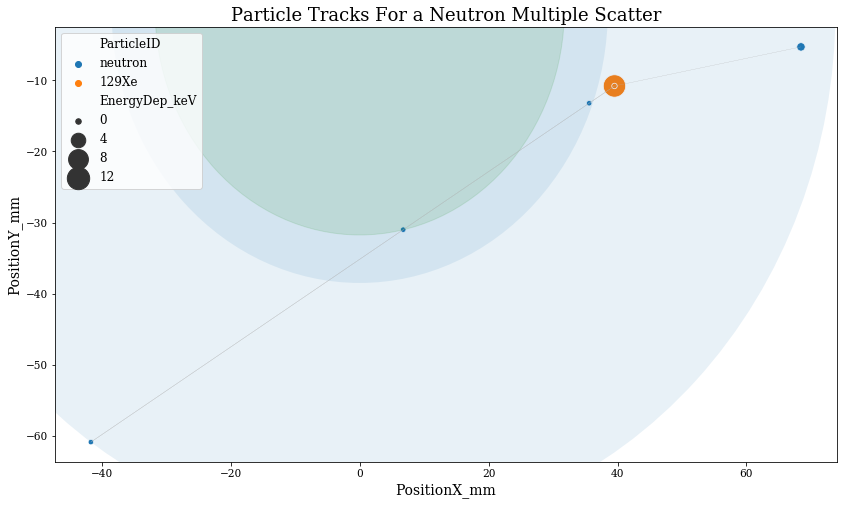

In [46]:
# Another event, neutrons only.
dfSingleParticle_n = dfExploded_All.loc[dfExploded_All.EvtN == 6]

cryostatBoundary = plt.Circle((0, 0), 73.812, alpha = 0.1, label = 'Liquid Xenon')
PTFEBoundary = plt.Circle((0, 0), 38.5, alpha = 0.1, label = 'PTFE')
activeVolumeBoundary = plt.Circle((0, 0), 31.75, color = 'green', alpha = 0.1, label = 'Active Volume')

plt.figure(figsize = (14, 8))

plt.gcf().gca().add_artist(cryostatBoundary)
plt.gcf().gca().add_artist(PTFEBoundary)
plt.gcf().gca().add_artist(activeVolumeBoundary)

sns.scatterplot(x = 'PositionX_mm',
                y = 'PositionY_mm',
                data = dfSingleParticle_n,
                hue = 'ParticleID',
                size = 'EnergyDep_keV',
                sizes = (30, 500))
singleParticlePositions = dfSingleParticle_n[['PositionX_mm', 'PositionY_mm']].to_numpy()
for i in range(len(singleParticlePositions) - 1):
    distanceBetweenPoints = np.hypot(*(singleParticlePositions[i+1] - singleParticlePositions[i]))
    # Draw arrow only if points are separable
    if distanceBetweenPoints > 0.1:
        plt.arrow(*singleParticlePositions[i], *(singleParticlePositions[i+1] - singleParticlePositions[i]), color = palette[-1], linewidth = 0.1)
plt.title('Particle Tracks For a Neutron Multiple Scatter')
plt.show()